In [122]:
import pandas as pd
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import json

import numpy as np

crew_df = pd.read_csv('../dataset/crew.csv', low_memory=False)
actors_df = pd.read_csv('../dataset/actors.csv', low_memory=False)
genres_df = pd.read_csv('../dataset/genres.csv', low_memory=False)
languages_df = pd.read_csv('../dataset/languages.csv', low_memory=False)
movies_df = pd.read_csv('../dataset/movies.csv', low_memory=False)
posters_df = pd.read_csv('../dataset/posters.csv', low_memory=False)

In [123]:
ratings_df = pd.read_csv('../dataset/ratings.csv', low_memory=False)

# Data Processing

In [3]:
crew_df.describe()

,id
count,4.720183e+06
mean,1.306020e+06
std,2.692652e+05
min,1.000001e+06
25%,1.065264e+06
50%,1.230888e+06
75%,1.506076e+06
max,1.941596e+06


In [4]:
actors_df.describe()

,id
count,5.798450e+06
mean,1.302557e+06
std,2.551917e+05
min,1.000001e+06
25%,1.079557e+06
50%,1.236225e+06
75%,1.483358e+06
max,1.941597e+06


In [5]:
genres_df.describe()

,id
count,1.046849e+06
mean,1.375578e+06
std,2.653416e+05
min,1.000001e+06
25%,1.139983e+06
50%,1.336303e+06
75%,1.589497e+06
max,1.941596e+06


In [6]:
languages_df.describe()

,id
count,1.038762e+06
mean,1.449603e+06
std,2.771259e+05
min,1.000001e+06
25%,1.204293e+06
50%,1.442066e+06
75%,1.689720e+06
max,1.941597e+06


In [7]:
movies_df.describe()

,id,date,minute,rating
count,9.415970e+05,849684.000000,760027.000000,90999.000000
mean,1.470799e+06,1998.522300,65.776516,3.244043
std,2.718158e+05,27.534865,154.828161,0.417281
min,1.000001e+06,1874.000000,1.000000,0.880000
25%,1.235400e+06,1986.000000,15.000000,3.020000
50%,1.470799e+06,2010.000000,62.000000,3.300000
75%,1.706198e+06,2019.000000,92.000000,3.510000
max,1.941597e+06,2031.000000,72000.000000,4.690000


In [8]:
posters_df.describe()

,id
count,9.415970e+05
mean,1.470799e+06
std,2.718158e+05
min,1.000001e+06
25%,1.235400e+06
50%,1.470799e+06
75%,1.706198e+06
max,1.941597e+06


In [9]:
crew_df = crew_df.dropna()
actors_df = actors_df.dropna()
genres_df = genres_df.dropna()
languages_df = languages_df.dropna()
movies_df = movies_df.dropna()
posters_df = posters_df.dropna()
ratings_df = ratings_df.dropna()

# Visualizations

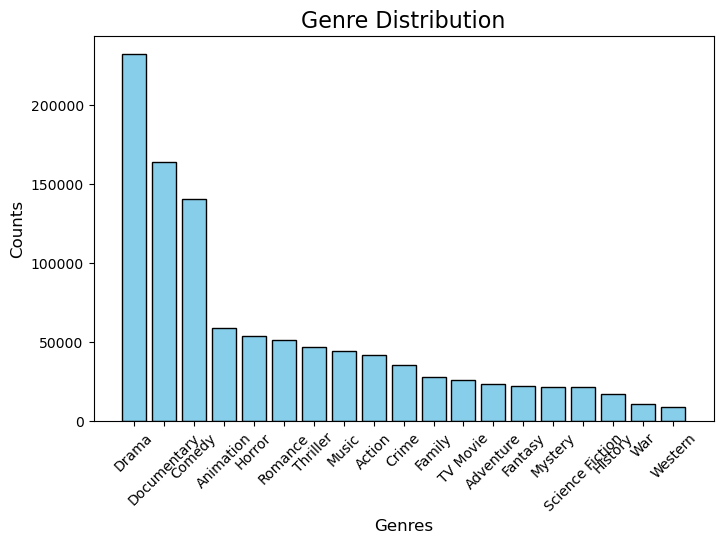

In [10]:
import matplotlib.pyplot as plt
counts = genres_df['genre'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.title('Genre Distribution', fontsize=16)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [20]:
counts = actors_df['name'].value_counts()

# Plotting
print(counts)

name
Mel Blanc               1044
Bess Flowers             689
Eric Roberts             571
Jagathy Sreekumar        459
Mammootty                430
                        ... 
Jadon Villarruz            1
Nicolas Chapt              1
Millie-Rose Crossley       1
Anvita Nehru               1
Isla Ashworth              1
Name: count, Length: 1305438, dtype: int64


In [ ]:
print(movies_df.columns)

Index(['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'], dtype='object')


# Ratings Based Recommender

In [124]:
movies_df.fillna(0, inplace=True)
ratings_df.fillna(0, inplace=True)
crew_df.fillna(0, inplace=True)
actors_df.fillna(0, inplace=True)
genres_df.fillna(0, inplace=True)
languages_df.fillna(0, inplace=True)
posters_df.fillna(0, inplace=True)

In [125]:
# Ratings-Based Recommendation
# Load and prepare data
if ratings_df.size > 0:
    reader = Reader(rating_scale=(ratings_df['rating'].min(), ratings_df['rating'].max()))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

    # Split data and train SVD model
    trainset, testset = train_test_split(data, test_size=0.2)
    svd = SVD()
    svd.fit(trainset)

    # Predict on test set
    predictions = svd.test(testset)

    # Evaluate performance
    rmse = accuracy.rmse(predictions)  # Root Mean Square Error
    mae = accuracy.mae(predictions)    # Mean Absolute Error

RMSE: 1.2360
MAE:  1.0786


In [164]:
print(movies_df['name'])

0                                    Barbie
1                                  Parasite
2         Everything Everywhere All at Once
3                                Fight Club
4                                La La Land
                        ...                
941592                                   神笛
941593                        蟲極道蜜団子抗争編 壱ノ巻
941594                        蟲極道蜜団子抗争編 弐ノ巻
941595                                   重生
941596                               青ひげ公の城
Name: name, Length: 941597, dtype: object


In [188]:
all_movie_ids = movies_df.head(10000)['id'].unique()


In [241]:
def predict():
    user_id = 'hamell'
    num_recommendations = 5
    top_recommendations = []

    if ratings_df.size > 0:
        # Get all movie IDs in the dataset
        # Filter out movies the user has already rated
        rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']
        unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies]
        # Predict ratings for each unrated movie
        predictions = [(movie_id, svd.predict(user_id, movie_id).est) for movie_id in unrated_movies]
        sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

        predicted_ratings_df = pd.DataFrame(predictions, columns=['movieId', 'rating']).set_index('movieId')
        print('overall recs')
        # Step 5: Get Top 5 Recommendations with Valid Titles
        for movie_id, predicted_rating in sorted_predictions:
            # Retrieve title
            movie = movies_df[movies_df['id'] == movie_id]
            title = movies_df[movies_df['id'] == movie_id]['name']
            poster = posters_df[posters_df['id'] == movie_id]['link']
            #genre = movies_df[genres_df['id'] == movie_id]['genre']
            
            # Check if the title exists and is not empty
            if not title.empty:
                print(title)
                json_obj = movie.to_dict(orient='records')
                json_obj[0]['poster'] = poster.values[0]
                top_recommendations.append(json_obj)
            
            # Stop once we have 5 valid recommendations
            if len(top_recommendations) == num_recommendations:
                break
        print("by genre")
        top_genres = genres_df[genres_df['id'] == top_recommendations[0][0]['id']]['genre']
        top_genres = top_genres.values

        for movie_id, predicted_rating in sorted_predictions:
            # Retrieve title
            movie = movies_df[movies_df['id'] == movie_id]
            title = movies_df[movies_df['id'] == movie_id]['name']
            genre = genres_df[genres_df['id'] == movie_id]['genre']
            genre = genre.values
            # Check if the title exists and is not empty
            if not title.empty:
                if set(genre) & set(top_genres):
                    id_exists = any(obj[0]['id'] == movie_id for obj in top_recommendations)
                    print(id_exists)
                    if id_exists == False:
                        print('new id', title.values[0])
                        json_obj = movie.to_dict(orient='records')
                        json_obj[0]['poster'] = poster.values[0]
                        top_recommendations.append(json_obj)
            
            # Stop once we have 5 valid recommendations
            if len(top_recommendations) == (2*num_recommendations):
                break
        top_cast = crew_df[crew_df['id'] == top_recommendations[0][0]['id']]['name']
        top_cast = top_cast.values
        for movie_id, predicted_rating in sorted_predictions:
            # Retrieve title
            movie = movies_df[movies_df['id'] == movie_id]
            title = movies_df[movies_df['id'] == movie_id]['name']
            cast = crew_df[crew_df['id'] == movie_id]['name']
            cast = cast.values
            # Check if the title exists and is not empty
            if not title.empty:
                if set(cast) & set(top_cast):
                    id_exists = any(obj[0]['id'] == movie_id for obj in top_recommendations)
                    print(id_exists)
                    if id_exists == False:
                        print('new id', title.values[0])
                        json_obj = movie.to_dict(orient='records')
                        json_obj[0]['poster'] = poster.values[0]
                        top_recommendations.append(json_obj)
            
            # Stop once we have 5 valid recommendations
            if len(top_recommendations) == (3*num_recommendations):
                break

        return json.dumps(top_recommendations)
    else:
        top_recommendations = movies_df.sample(n=(4*num_recommendations)).values.tolist()
        return top_recommendations

In [242]:
predict()

overall recs
86    Mean Girls
Name: name, dtype: object
0    Barbie
Name: name, dtype: object
1    Parasite
Name: name, dtype: object
2    Everything Everywhere All at Once
Name: name, dtype: object
3    Fight Club
Name: name, dtype: object
by genre
True
True
True
True
True
False
new id La La Land
False
new id Oppenheimer
False
new id Interstellar
False
new id Joker
False
new id Whiplash
True
False
new id Dune
False
new id Inception
False
new id American Psycho
False
new id Scott Pilgrim vs. the World
False
new id Blade Runner 2049


'[[{"id": 1000087, "name": "Mean Girls", "date": 2004.0, "tagline": "Welcome to girl world.", "description": "Cady Heron is a hit with The Plastics, the A-list girl clique at her new school, until she makes the mistake of falling for Aaron Samuels, the ex-boyfriend of alpha Plastic Regina George.", "minute": 97.0, "rating": 3.83, "poster": "https://a.ltrbxd.com/resized/film-poster/4/6/0/4/9/46049-mean-girls-0-230-0-345-crop.jpg?v=e6378abb7b"}], [{"id": 1000001, "name": "Barbie", "date": 2023.0, "tagline": "She\'s everything. He\'s just Ken.", "description": "Barbie and Ken are having the time of their lives in the colorful and seemingly perfect world of Barbie Land. However, when they get a chance to go to the real world, they soon discover the joys and perils of living among humans.", "minute": 114.0, "rating": 3.86, "poster": "https://a.ltrbxd.com/resized/film-poster/2/7/7/0/6/4/277064-barbie-0-230-0-345-crop.jpg?v=1b83dc7a71"}], [{"id": 1000002, "name": "Parasite", "date": 2019.0, "

In [128]:
print(genres_df)

              id      genre
0        1000001     Comedy
1        1000001  Adventure
2        1000002     Comedy
3        1000002   Thriller
4        1000002      Drama
...          ...        ...
1046844  1941563      Drama
1046845  1941566      Crime
1046846  1941569      Crime
1046847  1941596     Action
1046848  1941596      Crime

[1046849 rows x 2 columns]
